# Lab 4 Serving
- Find the best model 
- Create session to Kubeflow Pipelines (we will be utilizing the open source Seldon that comes with pre-packaged with Kubeflow)
- Create a pipeline that only creates a Seldon pod for serving our model

# Create KFP Client Object
### Please update endpoint, api_username and api_password as per your enviornment.
* endpoint is kubeflow url.
* api_username is AD username.
* api_password is AD user password.

In [ ]:
%kubeRefresh

In [ ]:
%loadMlflow

In [ ]:
%Setexp --name <YOUR INITITALS HERE>-bike-sharing-use-case

In [ ]:
import mlflow

best_run_df = mlflow.search_runs(order_by=['metrics.RMSE_CV ASC'], max_results=1)
if len(best_run_df.index) == 0:
    raise Exception(f"Found no runs for experiment '{experiment_name}'")

best_run = mlflow.get_run(best_run_df.at[0, 'run_id'])
best_model_uri = f"{best_run.info.artifact_uri}/model"
best_model = mlflow.sklearn.load_model(best_model_uri)

In [ ]:
# print best run info
print("Best run info:")
print(f"Run id: {best_run.info.run_id}")
print(f"Run parameters: {best_run.data.params}")
print("Run score: RMSE_CV = {:.4f}\n\n".format(best_run.data.metrics['RMSE_CV']))
print(f"Run model URI: {best_model_uri}")

## Kubeflow endpoint 
- Grab your kubeflow endpoint and update the endpoint variable <br>
- Update the username and password variable with your own <br>
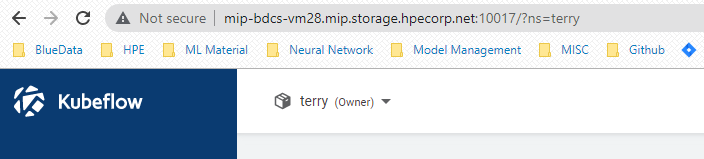

In [ ]:
import kfp
import json
import kfp.dsl as dsl

import requests, kfp


endpoint = "<Your kubeflow endpoint>" # Kubeflow Url
api_username  = "" # Username
api_password = "" # Password


def get_user_auth_session_cookie(url, username, password):
    url = url.replace('/pipeline', '')
    get_response = requests.get(url)
    if 'auth' in get_response.url:
        credentials = {'login': username, 'password': password}
        # Authenticate user
        session = requests.Session()
        session.post(get_response.url, data=credentials)
        cookie_auth_key = 'authservice_session'
        cookie_auth_value = session.cookies.get(cookie_auth_key)
        if cookie_auth_value:
            return cookie_auth_key + '=' + cookie_auth_value

session_cookie = get_user_auth_session_cookie(endpoint,api_username,api_password)
client = kfp.Client(host=endpoint,cookies=session_cookie)


# #For as ssl enabled system, set both kubeflow url with '/pipeline' at the end and location of certificate.
# url = "<Your kubeflow endpoint>"
# cert = "cert.pem"

# from ezmeral_kf_utils import KfSession
# K = KfSession(url, cert)
# client=K.kf_client()

In [ ]:
# List the current kubeflow pipelines
print(client.list_pipelines())

## K8s Resource JSON For Seldon Deployment
### Please replace the namespace name as per your enviornment
* <span style="color:red">best_model_uri</span> is the optimzed model from 9 runs.

In [ ]:
#Namespace Name 
NAMESPACE=""

DEPLOYMENT = {
  "apiVersion": "machinelearning.seldon.io/v1alpha3",
  "kind": "SeldonDeployment",
  "metadata": {
    "name": "bikesharing",
    "namespace": NAMESPACE
  },
  "spec": {
    "name": "bikesharing",
    "predictors": [
      {
        "graph": {
          "children": [],
          "implementation": "MLFLOW_SERVER",
          "modelUri": best_model_uri,
          "name": "bikesharing",
          "envSecretRefName": "mlflow-dp",
          "parameters": [
            {
              "name": "xtype",
              "type": "STRING",
              "value": "DataFrame"
            }
          ]
        },
        "name": "bikesharing",
        "replicas": 1,
        "svcOrchSpec": {
          "resources": {
            "limits": {
              "cpu": "1"
            },
            "requests": {
              "cpu": "0.5"
            }
          }
        },
        "componentSpecs": [
          {
            "spec": {
              "containers": [
                {
                  "resources": {
                    "limits": {
                      "cpu": "1"
                    },
                    "requests": {
                      "cpu": "0.5"
                    }
                  },
                "securityContext": {
                    "runAsUser": 0
                },
#                   "env": [
#                     {
#                       "name": "https_proxy",
#                       "value": "http://web-proxy.corp.hpecorp.net:8080"
#                     },
#                     {
#                       "name": "http_proxy",
#                       "value": "http://web-proxy.corp.hpecorp.net:8080"
#                     }
#                   ],
                  "name": "bikesharing",
                  "livenessProbe": {
                    "initialDelaySeconds": 80,
                    "failureThreshold": 200,
                    "periodSeconds": 60,
                    "successThreshold": 1,
                    "httpGet": {
                      "path": "/health/ping",
                      "port": "http",
                      "scheme": "HTTP"
                    }
                  },
                  "readinessProbe": {
                    "initialDelaySeconds": 80,
                    "failureThreshold": 200,
                    "periodSeconds": 60,
                    "successThreshold": 1,
                    "httpGet": {
                      "path": "/health/ping",
                      "port": "http",
                      "scheme": "HTTP"
                    }
                  }
                }
              ]
            }
          }
        ]
      }
    ]
  }
}


DEPLOYMENT = json.dumps(DEPLOYMENT)

## Submiting KFP Pipeline Which Will Deploy Trained Model Through Seldon Deployment

In [ ]:
@dsl.pipeline(
    name="Deploy Model for " + api_username,
    description="Deploy Trained Model Using Seldon"
)
def deploy_model():
    
    # Deploy mlflow model.
    op_seldondeployment = dsl.ResourceOp(
        name='Seldon deployment ' + api_username,
        k8s_resource=json.loads(DEPLOYMENT),
        action='create'
    )
    
    
client.create_run_from_pipeline_func(
    deploy_model,
    experiment_name="Bike Sharing Deployment for"  + api_username,
    arguments={},
)

## Prediction
### Deployment of seldon will take few minutes to comes to ready state, so wait for few minutes before actually executing the below cell.

In [ ]:
# Wait until both bikesharing pods are in the "running" state
!kubectl get pods

In [ ]:
import requests, json

KUBEFLOW_URL = endpoint.replace('/pipeline', '')

SELDON_DEPLOYMENT_NAME = "bikesharing"

headers = {
    'Accept': 'application/json',
    'Content-Type': 'application/json'
}

cookies = {
    'authservice_session': session_cookie.replace('authservice_session=', '')
}

input_data = [[1, 2, 1, 0, 0, 6, 0, 1, 0.24, 0.2879, 0.81, 0.0000], [1, 5, 1, 0, 0, 6, 1, 1, 0.24, 0.2879, 0.81, 0.0000]]
names = ['season', 'year', 'month', 'hour_of_day', 'is_holiday', 'weekday', 'is_workingday', 
         'weather_situation', 'temperature', 'feels_like_temperature', 'humidity', 'windspeed']
                                  
data = {"data":{"names": names, "ndarray": input_data}}
json_request= json.dumps(data)

URL = "{}/seldon/{}/{}/api/v1.0/predictions".format(KUBEFLOW_URL,NAMESPACE,SELDON_DEPLOYMENT_NAME)

response = requests.post(URL, headers=headers, cookies=cookies, data=json_request)
output = response.json()['data']['ndarray']
print("Rented Bikes Per Hours:\n")
for item in range(len(input_data)):
    print("Input Data: {} \n\nBikes Per Hour: {}\n".format({names[i]: input_data[item][i] for i in range(len(names))},output[item]))